<a href="https://colab.research.google.com/github/ingileif/BI188_Spring_2020/blob/master/Bi188_data_analysis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BI188 Spring 2020 : single-cell RNA-seq data analysis project
In this Python notebook you will read in a count matrix for a 10X Chromium dataset from the Wold Lab.  It contains scRNA-Seq data from mouse limbs early in development.

The count matrix was created with kallisto and bustools, using the command `kb`.  You will performs an analysis of the cell types and their marker genes.

The notebook uses kallisto and bustools to process the data, and SCANPY for analysis.  For more background information see:

* Melsted, P., Booeshaghi, A.S. et al. Modular and efficient pre-processing of single-cell RNA-seq. bioRxiv (2019). doi:10.1101/673285
* Wolf, F. A., Angere, P. and Theis, F.J. SCANPY: large-scale single-cell gene expression data analysis. Genome Biology (2018). doi:10.1186/s13059-017-1382-0


## Setup

In [0]:
# This is  used to time the running of the notebook
import time
start_time = time.time()

### Install python packages

In [0]:
%%time
# These packages are pre-installed on Google Colab, but are included 
# here to simplify running this notebook locally
!pip install matplotlib
!pip install scikit-learn
!pip install numpy
!pip install scipy
!pip3 install leidenalg
!pip install louvain
!pip install scanpy

     |████████████████████████████████| 2.4MB 2.8MB/s 
     |████████████████████████████████| 3.2MB 21.1MB/s 
     |████████████████████████████████| 2.2MB 2.5MB/s 
     |████████████████████████████████| 7.2MB 2.6MB/s 
     |████████████████████████████████| 102kB 9.8MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
CPU times: user 163 ms, sys: 58.7 ms, total: 222 ms
Wall time: 27.1 s


### Install kb-python
We have pre-run kallisto bustools to obtain the count matrix.  We do not need to install `kb` so we comment out the commands with # at the beginning of the line.

In [0]:
%%time
# install kb
# !pip install kb-python 

     |████████████████████████████████| 35.4MB 93kB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
  Created wheel for loompy: filename=loompy-3.0.6-cp36-none-any.whl size=47895 sha256=004c81d2056ed2baa5fd645c29e520a206f5f04c4129f5ed2aef1b4b33715551
  Stored in directory: /root/.cache/pip/wheels/f9/a4/90/5a98ad83419732b0fba533b81a2a52ba3dbe230a936ca4cdc9
  Created wheel for numpy-groupies: filename=numpy_groupies-0+unknown-cp36-none-any.whl size=28042 sha256=8304fa7f1f8239e84a3b0c8cb0c268bc02052dd7ebcaac54552811ba8b5ace1b
  Stored in directory: /root/.cache/pip/wheels/30/ac/83/64d5f9293aeaec63f9539142fc629a41af064cae1b3d8d94aa
Successfully built loompy numpy-groupies
CPU times: user 75.3 ms, sys: 25.3 ms, total: 101 ms
Wall time: 11.5 s


### Download the data
The following commands are used to download `fastqs` files for analysis, since we are starting with a count matrix we can comment them out with a # at the start of the line.


In [0]:
%%time
# Download the data from the 10x website
# !wget [include path to a fastqs file]

# unpack the downloaded files
# !tar -xvf [name of downloaded file]

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


### Download an index

To generate a count matrix from the `fastqs` file we need an index that describes how to map reads (from the fastqs file) to transcripts (i.e. known mRNA transcripts).  This index is species specific.  In our analysis we comment out this command.

In [0]:
# !kb ref -d mouse -i index.idx -g t2g.txt -f1 transcriptome.fasta

## Pseudoalignment and counting

### Run kallisto and bustools
As mentioned above, we have already run `kb`, but show the `kb` command to use for completeness.

In [0]:
# %%time
# !kb count --h5ad -i index.idx -g t2g.txt -x 10xv3 -o output --filter bustools -t 2 \
# pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz \
# pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz \
# pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz \
# pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz

### Download the count matrices
To save time in this analysis we have pre-run kallisto bustools and stored the count matrixes locally on a server at Caltech.  We use the command `wget` to download the files.

Our data is stored in the files `adata.h5ad` and `t2g.txt`.  The count data is in the adata file. We also need a file that maps transcripts to genes, `t2g.txt`.  

In [0]:
!wget -O adata.h5ad https://caltech.box.com/shared/static/hlklw3m29n23j0czr8rwl61o6dq3dv2h.h5ad
!wget -O t2g.txt https://caltech.box.com/shared/static/yeeb25mvbl67t6fnehb07mbhq5nlq6kl.txt

--2020-05-15 16:41:05--  https://caltech.box.com/shared/static/hlklw3m29n23j0czr8rwl61o6dq3dv2h.h5ad
Resolving caltech.box.com (caltech.box.com)... 107.152.26.197
Connecting to caltech.box.com (caltech.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/hlklw3m29n23j0czr8rwl61o6dq3dv2h.h5ad [following]
--2020-05-15 16:41:05--  https://caltech.box.com/public/static/hlklw3m29n23j0czr8rwl61o6dq3dv2h.h5ad
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://caltech.app.box.com/public/static/hlklw3m29n23j0czr8rwl61o6dq3dv2h.h5ad [following]
--2020-05-15 16:41:05--  https://caltech.app.box.com/public/static/hlklw3m29n23j0czr8rwl61o6dq3dv2h.h5ad
Resolving caltech.app.box.com (caltech.app.box.com)... 107.152.26.199
Connecting to caltech.app.box.com (caltech.app.box.com)|107.152.26.199|:443... connected.
HTTP request sent, awaiting response

### Read data into python
We just used kallisto to obtain a count matrix but now we install `scanpy` which is a python package for analysis of scRNA-Seq data.  We also install a few python and matlab packages that will be used for data processing and plotting.

To read up on scanpy go to:
https://scanpy.readthedocs.io/en/stable/

In [0]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


We set a few scanpy parameters.

In [0]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.6 anndata==0.7.1 umap==0.4.2 numpy==1.18.4 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.8.2 louvain==0.7.0


Earlier we downloaded the data file, `adata.h5ad` and the map `t2g.txt`.  We now read the data from the files into python, and name the variables `adata` and `t2g`.  In the last line we type the name of the variable, `adata` and the message printed to the screen confirms that we have a data matrix of size 603685 × 55421 and associated variable adata.var contains the a list of `gene_id` to `gene_name`.

In [0]:
# load the unfiltered matrix
results_file = 'adata.h5ad'  # the file that will store the analysis results
adata = anndata.read_h5ad("adata.h5ad")
adata.var["gene_id"] = adata.var.index.values

t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])
adata.var.index = adata.var["gene_name"]

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [0]:
adata

AnnData object with n_obs × n_vars = 603685 × 55421 
    var: 'gene_id', 'gene_name'

## Basic Quality Control
The first step of the analysis is to do basic quality control (QC).  

### Test for library saturation

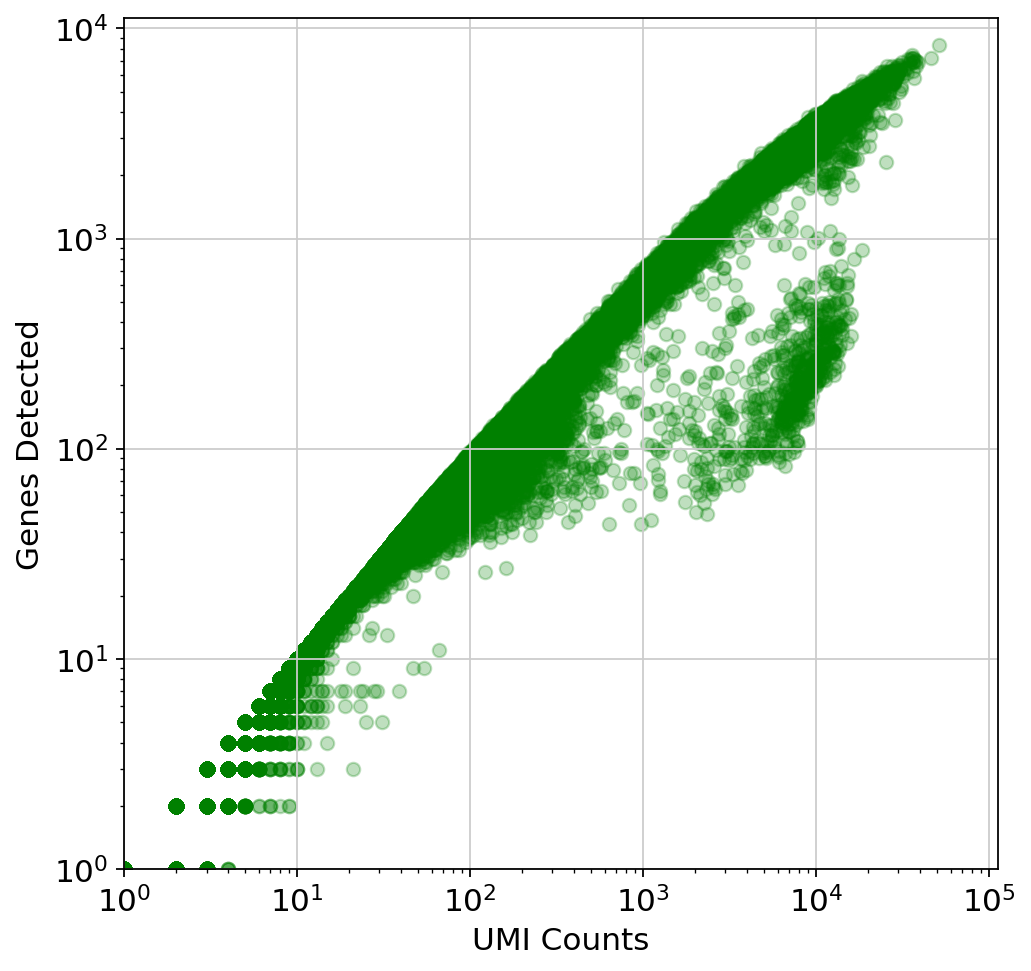

In [0]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(7, 7))

x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1)
ax.set_ylim(1)


plt.show()

This plot is very misleading, as even the small alpha can't accurately show how many points are stacked at one location (This takes about a minute to run since there are a lot of points)

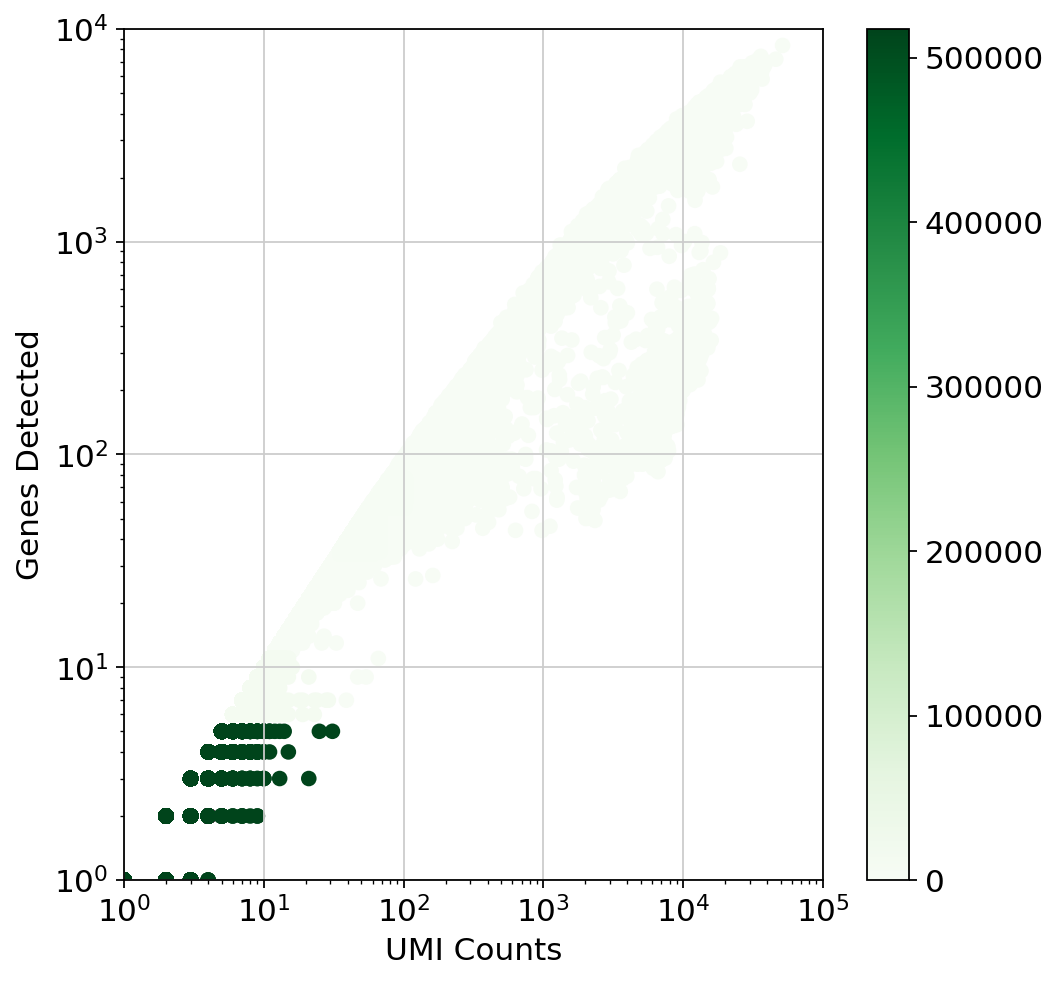

In [0]:
fig, ax = plt.subplots(figsize=(7,7))

#histogram definition
bins = [1500, 1500] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]


s = ax.scatter(x2, y2, c=z2, cmap='Greens')  
fig.colorbar(s, ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")

ax.set_xlim(1, 10**5)
ax.set_ylim(1, 10**4)

plt.show()

### Examine the knee plot

The "knee plot" was introduced in the Drop-seq paper: 
- Macosko et al., [Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets](https://www.cell.com/fulltext/S0092-8674(15)00549-8), 2015. DOI:10.1016/j.cell.2015.05.002

In this plot cells are ordered by the number of UMI counts associated to them (shown on the *x*-axis), and the fraction of droplets with at least that number of cells is shown on the *y*-axis:

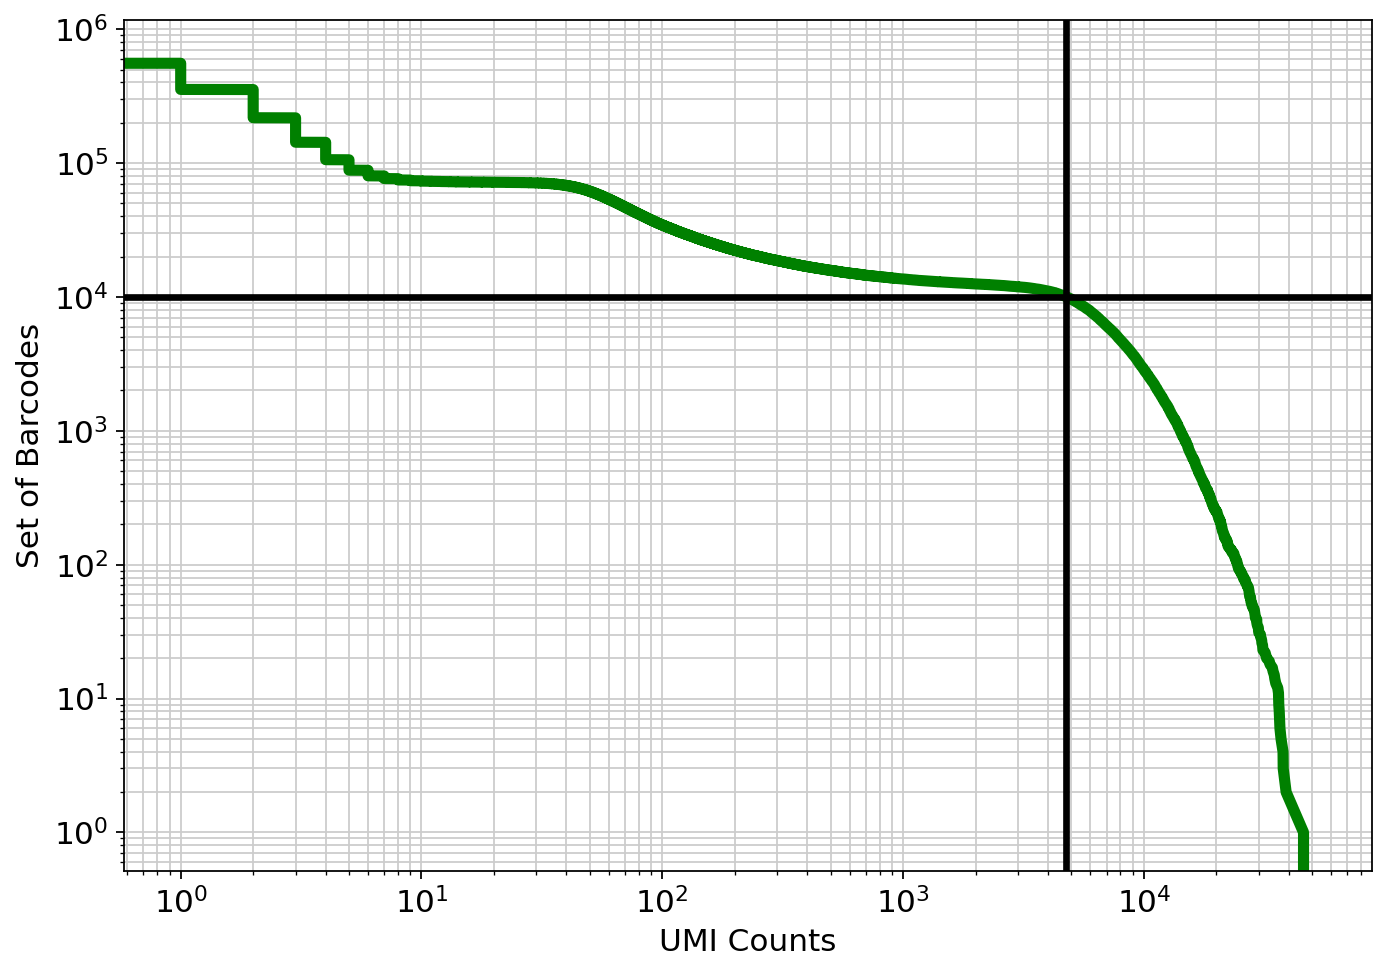

In [0]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
expected_num_cells =  10000#@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(knee, range(len(knee)), linewidth=5, color="g")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

## Analysis

It is useful to examine mitochondrial genes, which are important for quality control. [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics) write that

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

Note you can also use the function `pp.calculate_qc_metrics` to compute the fraction of mitochondrial genes and additional measures.

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

normalizing counts per cell


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


    finished (0:00:00)


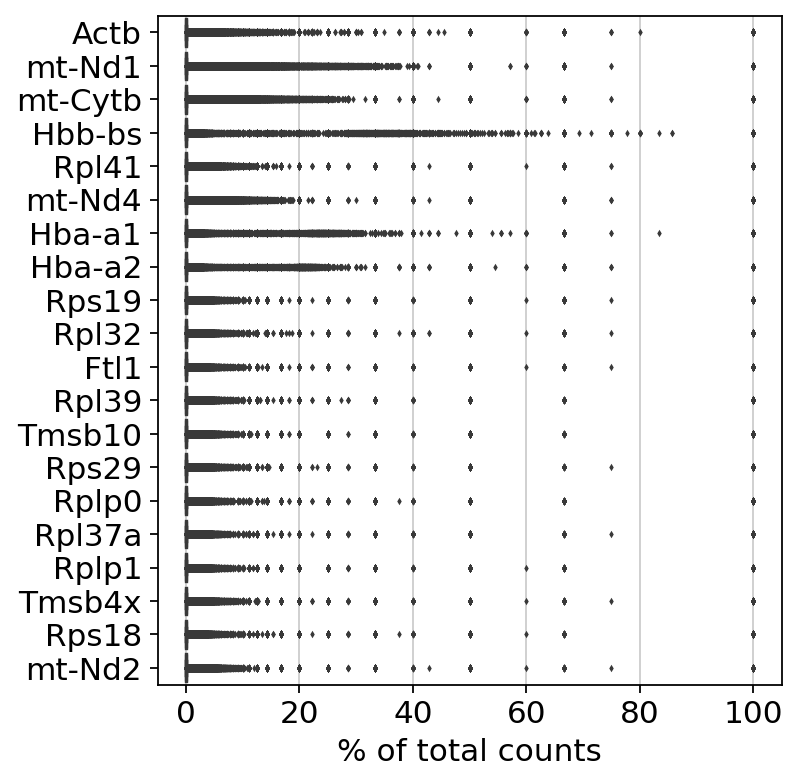

In [0]:
sc.pl.highest_expr_genes(adata, n_top=20)

### Filter

Begin by filtering cells according to various criteria. First, a filter for genes and cells based on minimum thresholds:

In [0]:
# Removes cells with less than 1070 umi counts
adata = adata[np.asarray(adata.X.sum(axis=1)).reshape(-1) > 1000]

# Removes genes with 0 umi counts
adata = adata[:, np.asarray(adata.X.sum(axis=0)).reshape(-1) > 0]

In [0]:
adata

View of AnnData object with n_obs × n_vars = 13461 × 34450 
    var: 'gene_id', 'gene_name'

In [0]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 304 cells that have less than 200 genes expressed


Trying to set attribute `.obs` of view, copying.


filtered out 4607 genes that are detected in less than 3 cells


In [0]:
adata

AnnData object with n_obs × n_vars = 13157 × 29843 
    obs: 'n_genes'
    var: 'gene_id', 'gene_name', 'n_cells'

Next, filter by mitochondrial gene content

In [0]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

Perform a QC check of the counts post-filtering

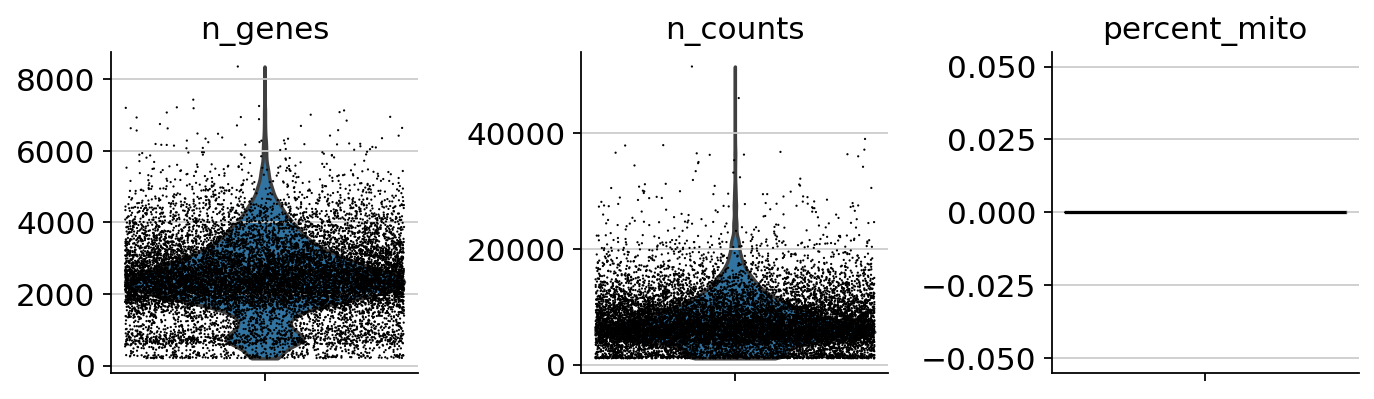

In [0]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

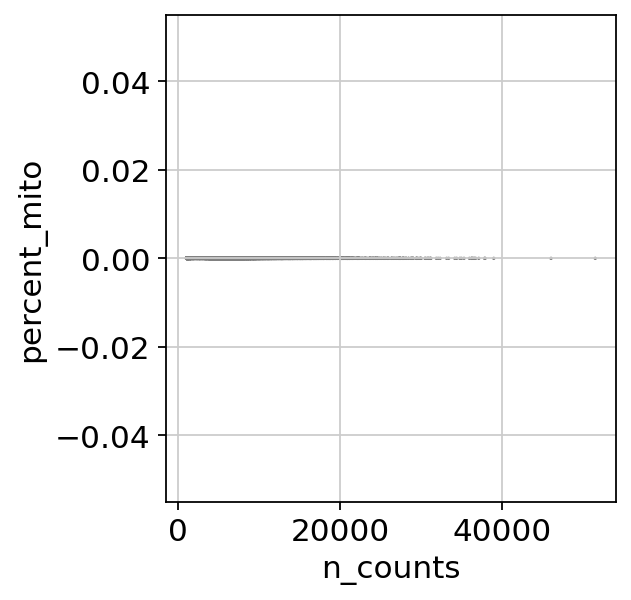

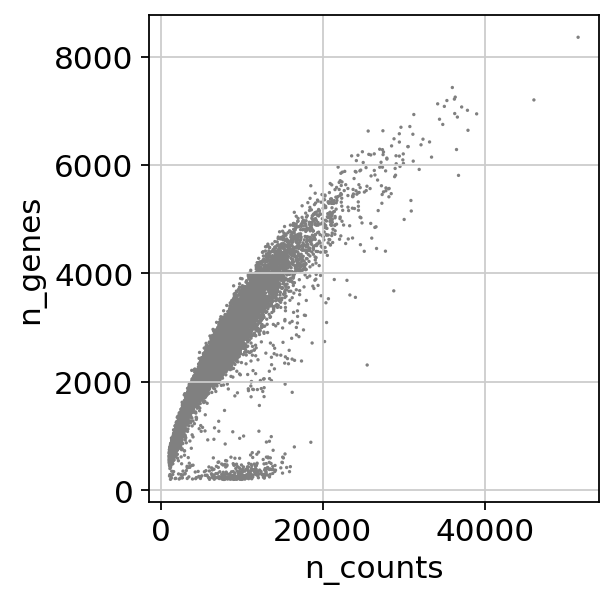

In [0]:
#examine mitochondrial content 
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [0]:
# Create a mask to filter out cells with more than 6500 genes, less than 200 genes or less than 0.2 mitochondrial umi counts
mask = np.logical_or((adata.obs.n_genes < 6500).values, (adata.obs.n_genes > 200).values, (adata.obs.percent_mito < 0.2).values)

In [0]:
#filter
adata = adata[mask, :]

In [0]:
adata

View of AnnData object with n_obs × n_vars = 13157 × 29843 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_id', 'gene_name', 'n_cells'

### Normalize counts

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [0]:
# normalize counts in each cell to be equal
sc.pp.normalize_total(adata, target_sum=10**4)

normalizing counts per cell
    finished (0:00:26)


Log the counts

In [0]:
# Replace raw counts with their logarithm
sc.pp.log1p(adata)

/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


Lets now look at the highest expressed genes after filtering, normalization, and log

normalizing counts per cell
    finished (0:00:00)


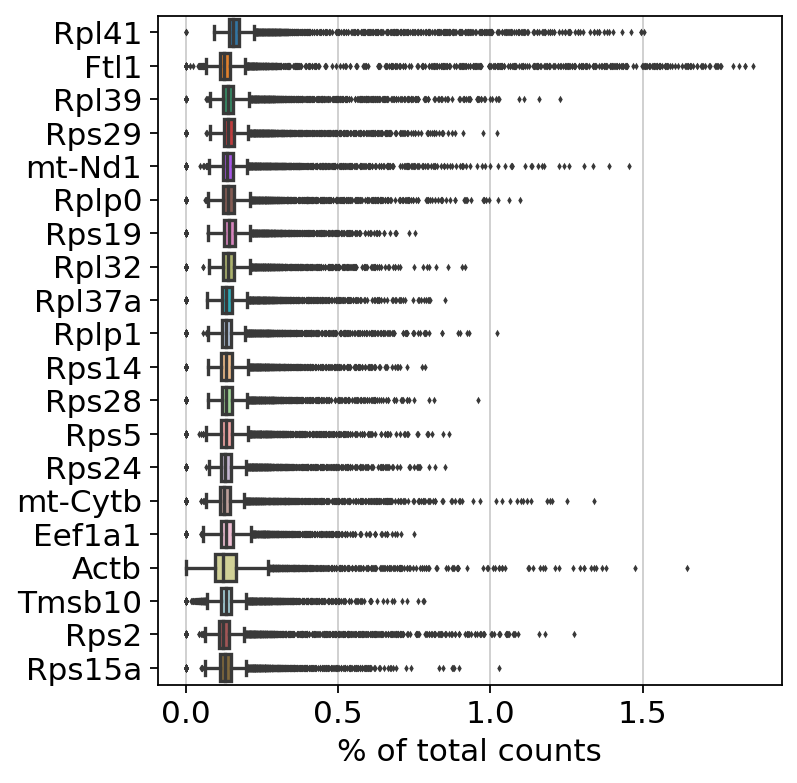

In [0]:
sc.pl.highest_expr_genes(adata, n_top=20)

Set the `.raw` attribute of AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

The unnormalized data is stored in `.raw`.

In [0]:
adata.raw = adata

<div class="alert alert-info">

**Note**
The result of the following highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools.

</div>

### Identify highly-variable genes.

In [0]:
# flavor="cell_ranger" is consistent with Seurat and flavor="suerat" is not consistent with Seurat
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=8, min_disp=1, n_top_genes=2000, flavor="cell_ranger", n_bins=20)

extracting highly variable genes
If you pass `n_top_genes`, all cutoffs are ignored.
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


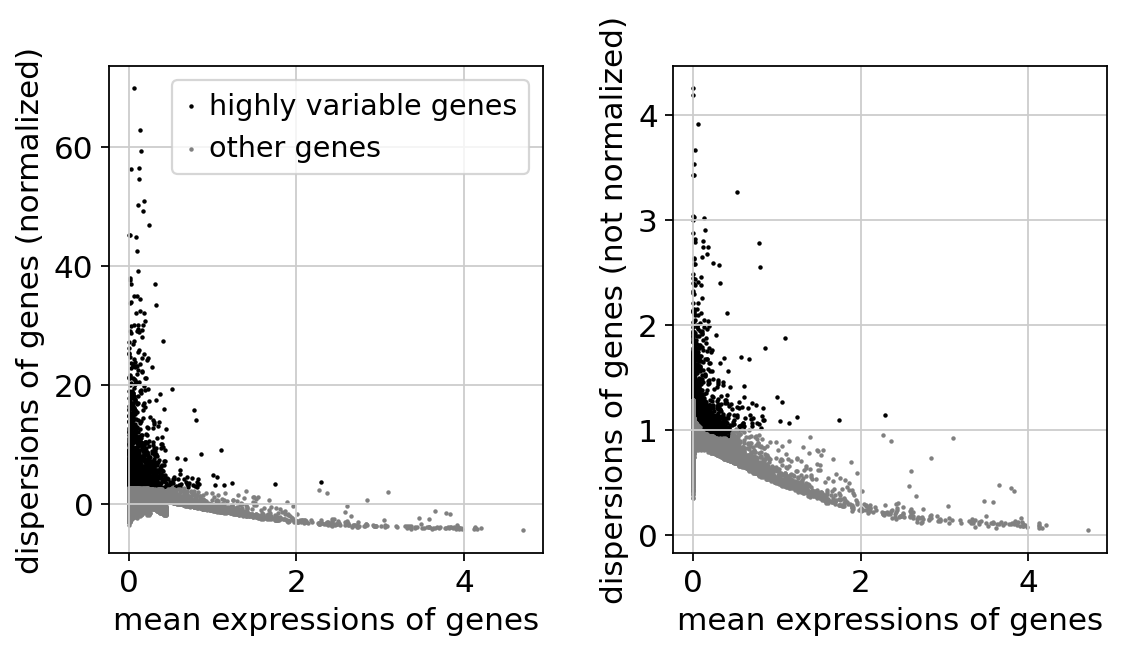

In [0]:
sc.pl.highly_variable_genes(adata)

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

We do not regress out as per https://github.com/theislab/scanpy/issues/526

In [0]:
# sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

### Scaling the data
Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [0]:
sc.pp.scale(adata, max_value=10)

### Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [0]:
# We perform PCA on just the highly variable genes
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:03)


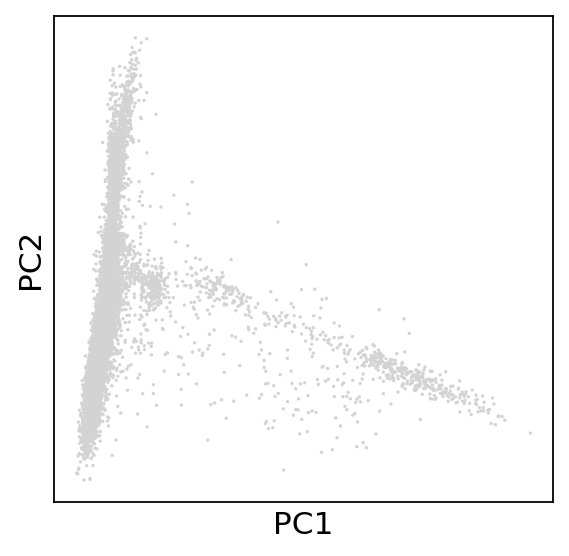

In [0]:
sc.pl.pca(adata)

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.leiden()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

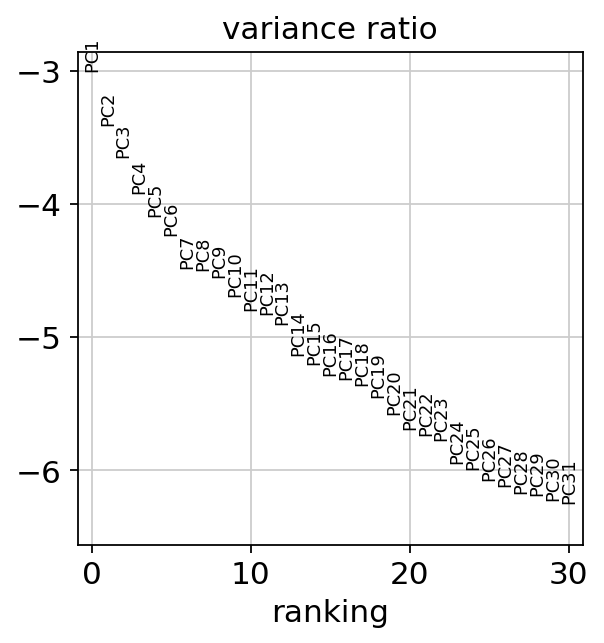

In [0]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result if you'd like.

In [0]:
!mkdir write

In [0]:
adata.write(results_file)

In [0]:
adata

AnnData object with n_obs × n_vars = 13157 × 29843 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_id', 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### Compute the neighborhood graph

Next we compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. In order to be consistent with Seurat's results, we use the following values.

In [0]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:14)


### Embed the neighborhood graph

### UMAP

UMAP (UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction) is a manifold learning technique that can also be used to visualize cells. It was published in:

- McInnes, Leland, John Healy, and James Melville. "Umap: Uniform manifold approximation and projection for dimension reduction." arXiv preprint arXiv:1802.03426 (2018).

We run that to visualize the results:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [0]:
sc.tl.tsne(adata)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:02:11)


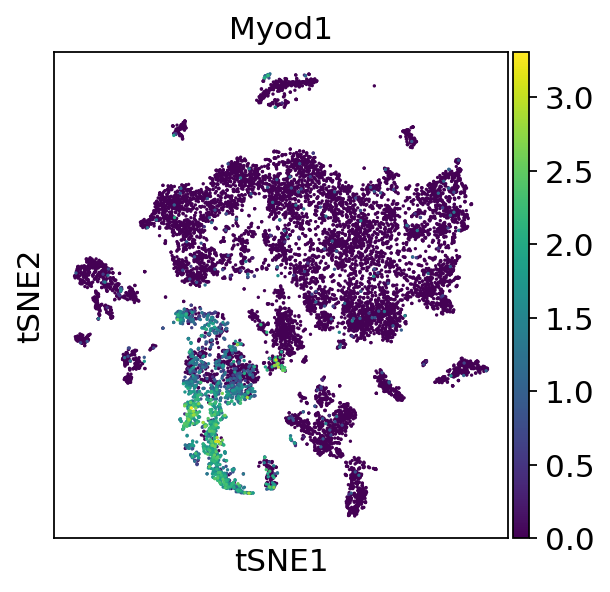

In [0]:
sc.pl.tsne(adata, color=['Myod1'])

### Cluster the neighborhood graph

### Clustering

There are many algorithms for clustering cells, and while they have been compared in detail in various benchmarks (see e.g., [Duo et al. 2018](https://f1000research.com/articles/7-1141/v2)), there is no univerally agreed upon method. Here we demonstrate clustering using [Leiden](https://en.wikipedia.org/wiki/Louvain_modularity), which is a popular method for clustering single-cell RNA-seq data. The method was published in 

- Blondel, Vincent D; Guillaume, Jean-Loup; Lambiotte, Renaud; Lefebvre, Etienne (9 October 2008). "Fast unfolding of communities in large networks". Journal of Statistical Mechanics: Theory and Experiment. 2008 (10): P10008.

Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [0]:
sc.tl.leiden(adata, resolution=0.5, random_state=42)

running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


A plot of the clusters is shown below:

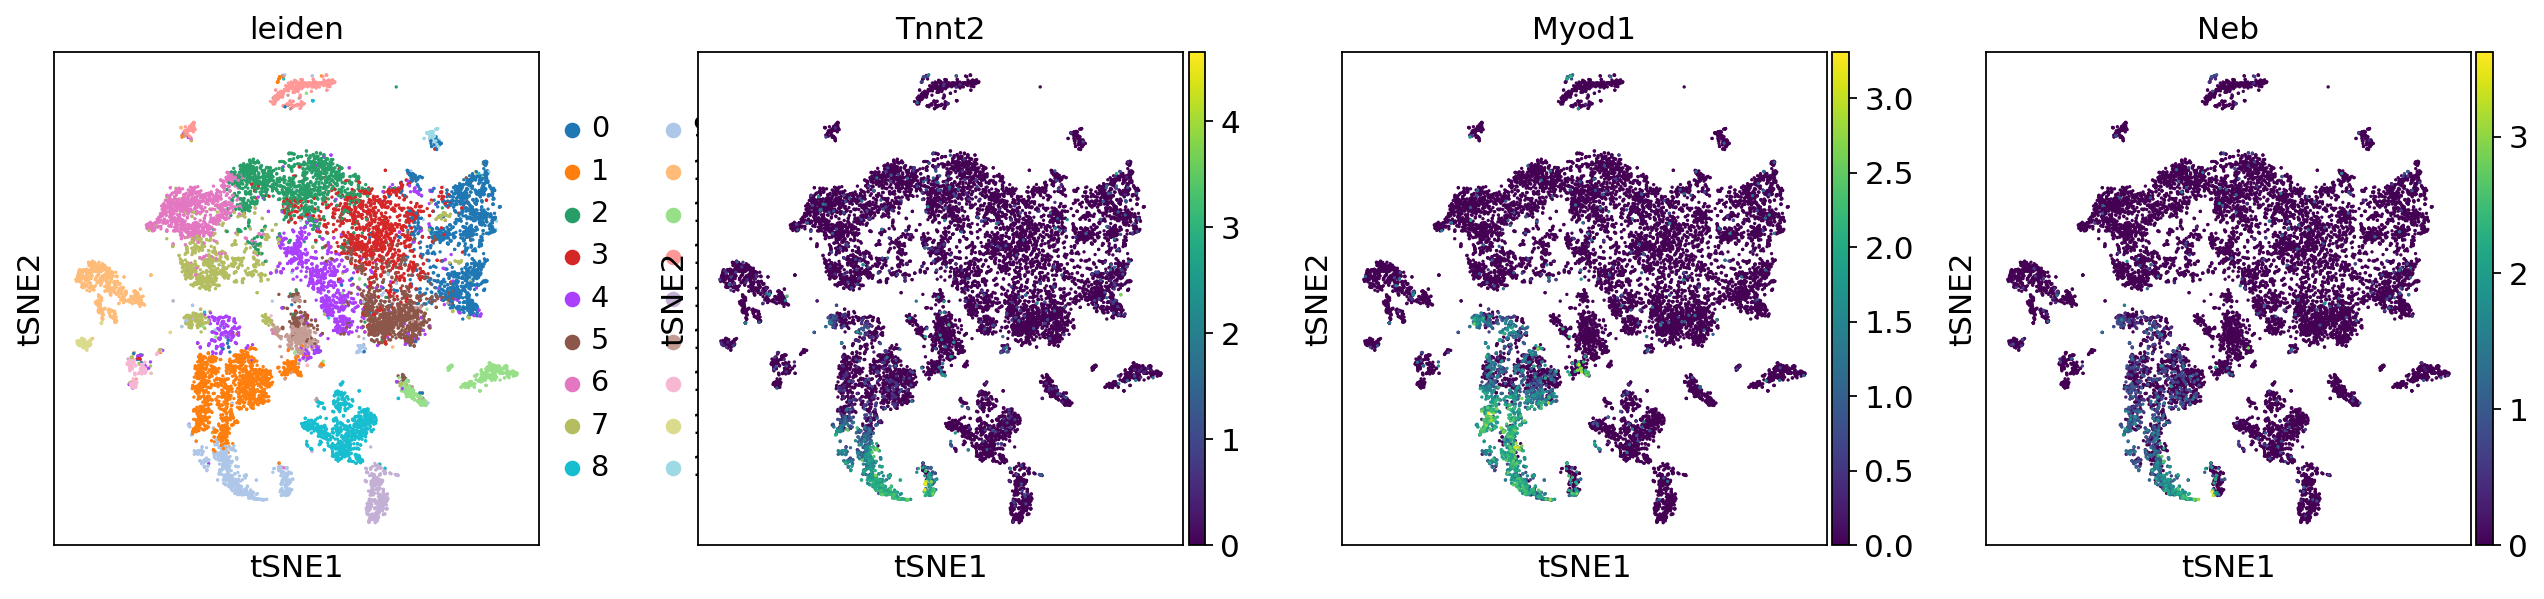

In [0]:
sc.pl.tsne(adata, color=['leiden', 'Tnnt2', 'Myod1', 'Neb'])

Save the result.

In [0]:
adata.write(results_file)

### Find marker genes

A key aspect of annotating a cell atlas is identifying "marker genes". These are genes specific to individual clusters that "mark" them, and are important both for assigning functions to cell clusters, and for designing downstream experiments to probe activity of clusters. 

A gene marker analysis begins with ranking genes in each cluster according to how different they are relative to other clusters. Typically the t-test is used for this purpose.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


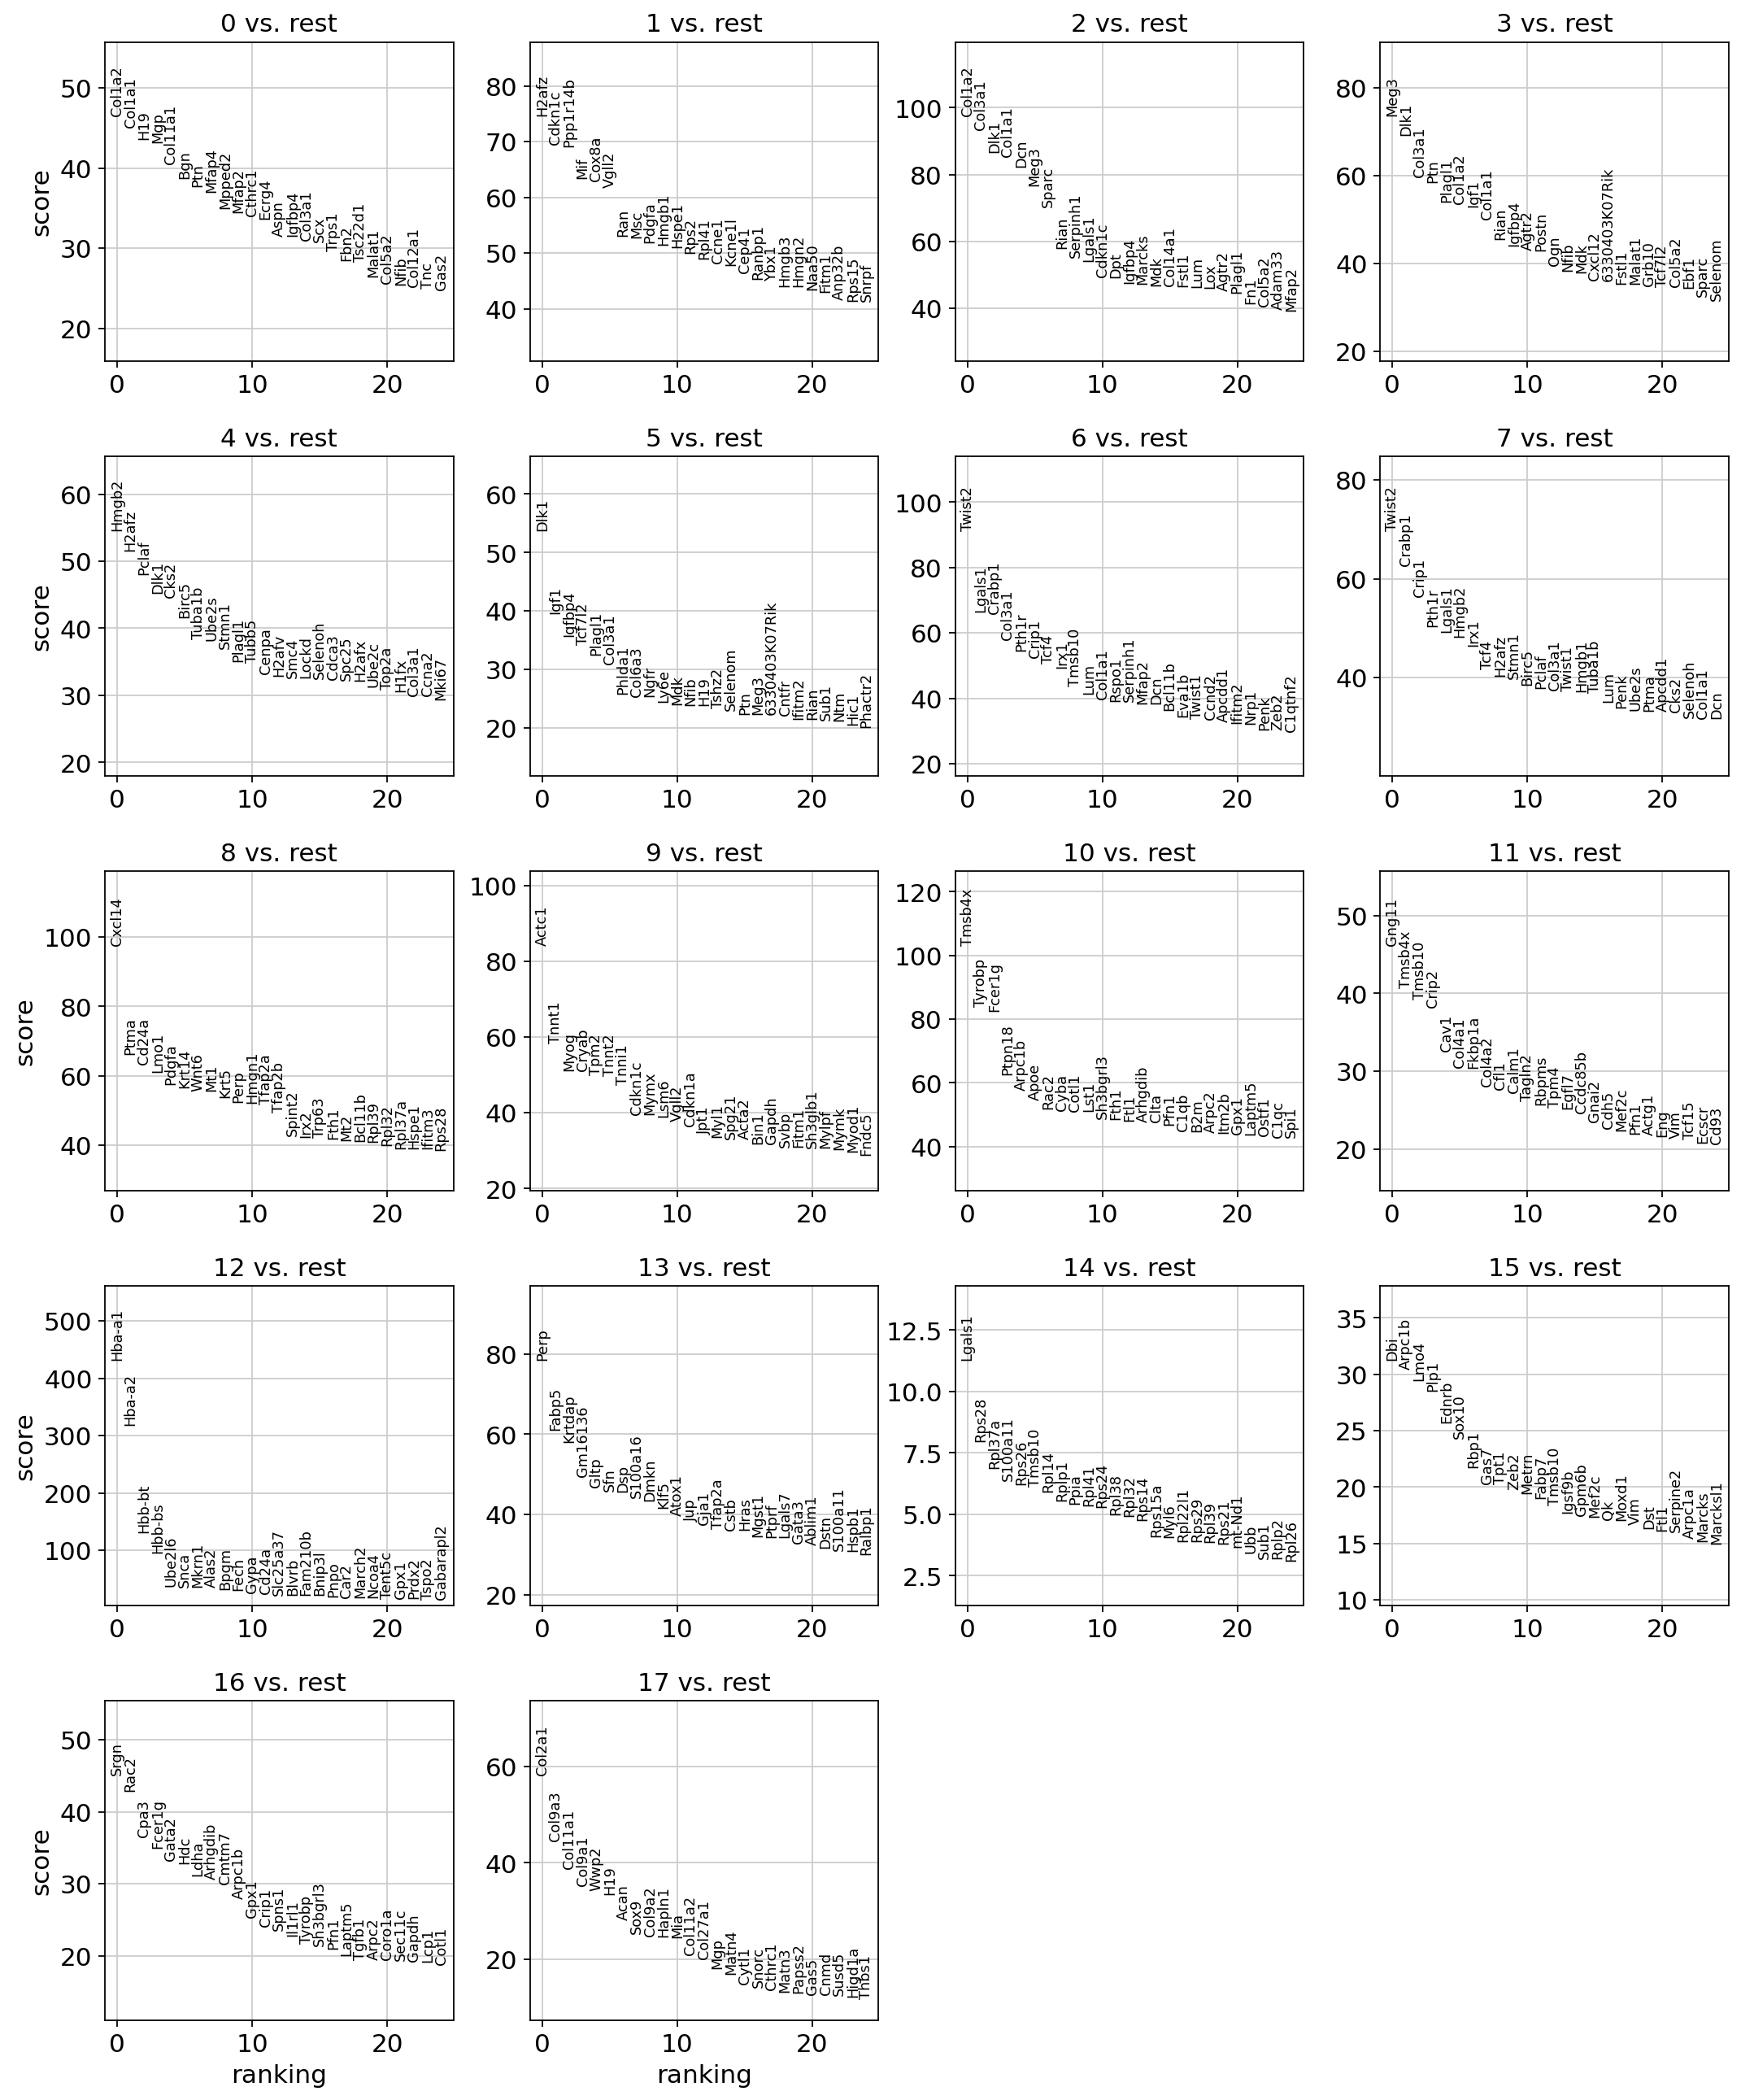

In [0]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test', corr_method="bonferroni")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [0]:
sc.settings.verbosity = 2  # reduce the verbosity

An alternative to the parametric t-test is the non-parametric [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test.

ranking genes
    finished (0:00:34)


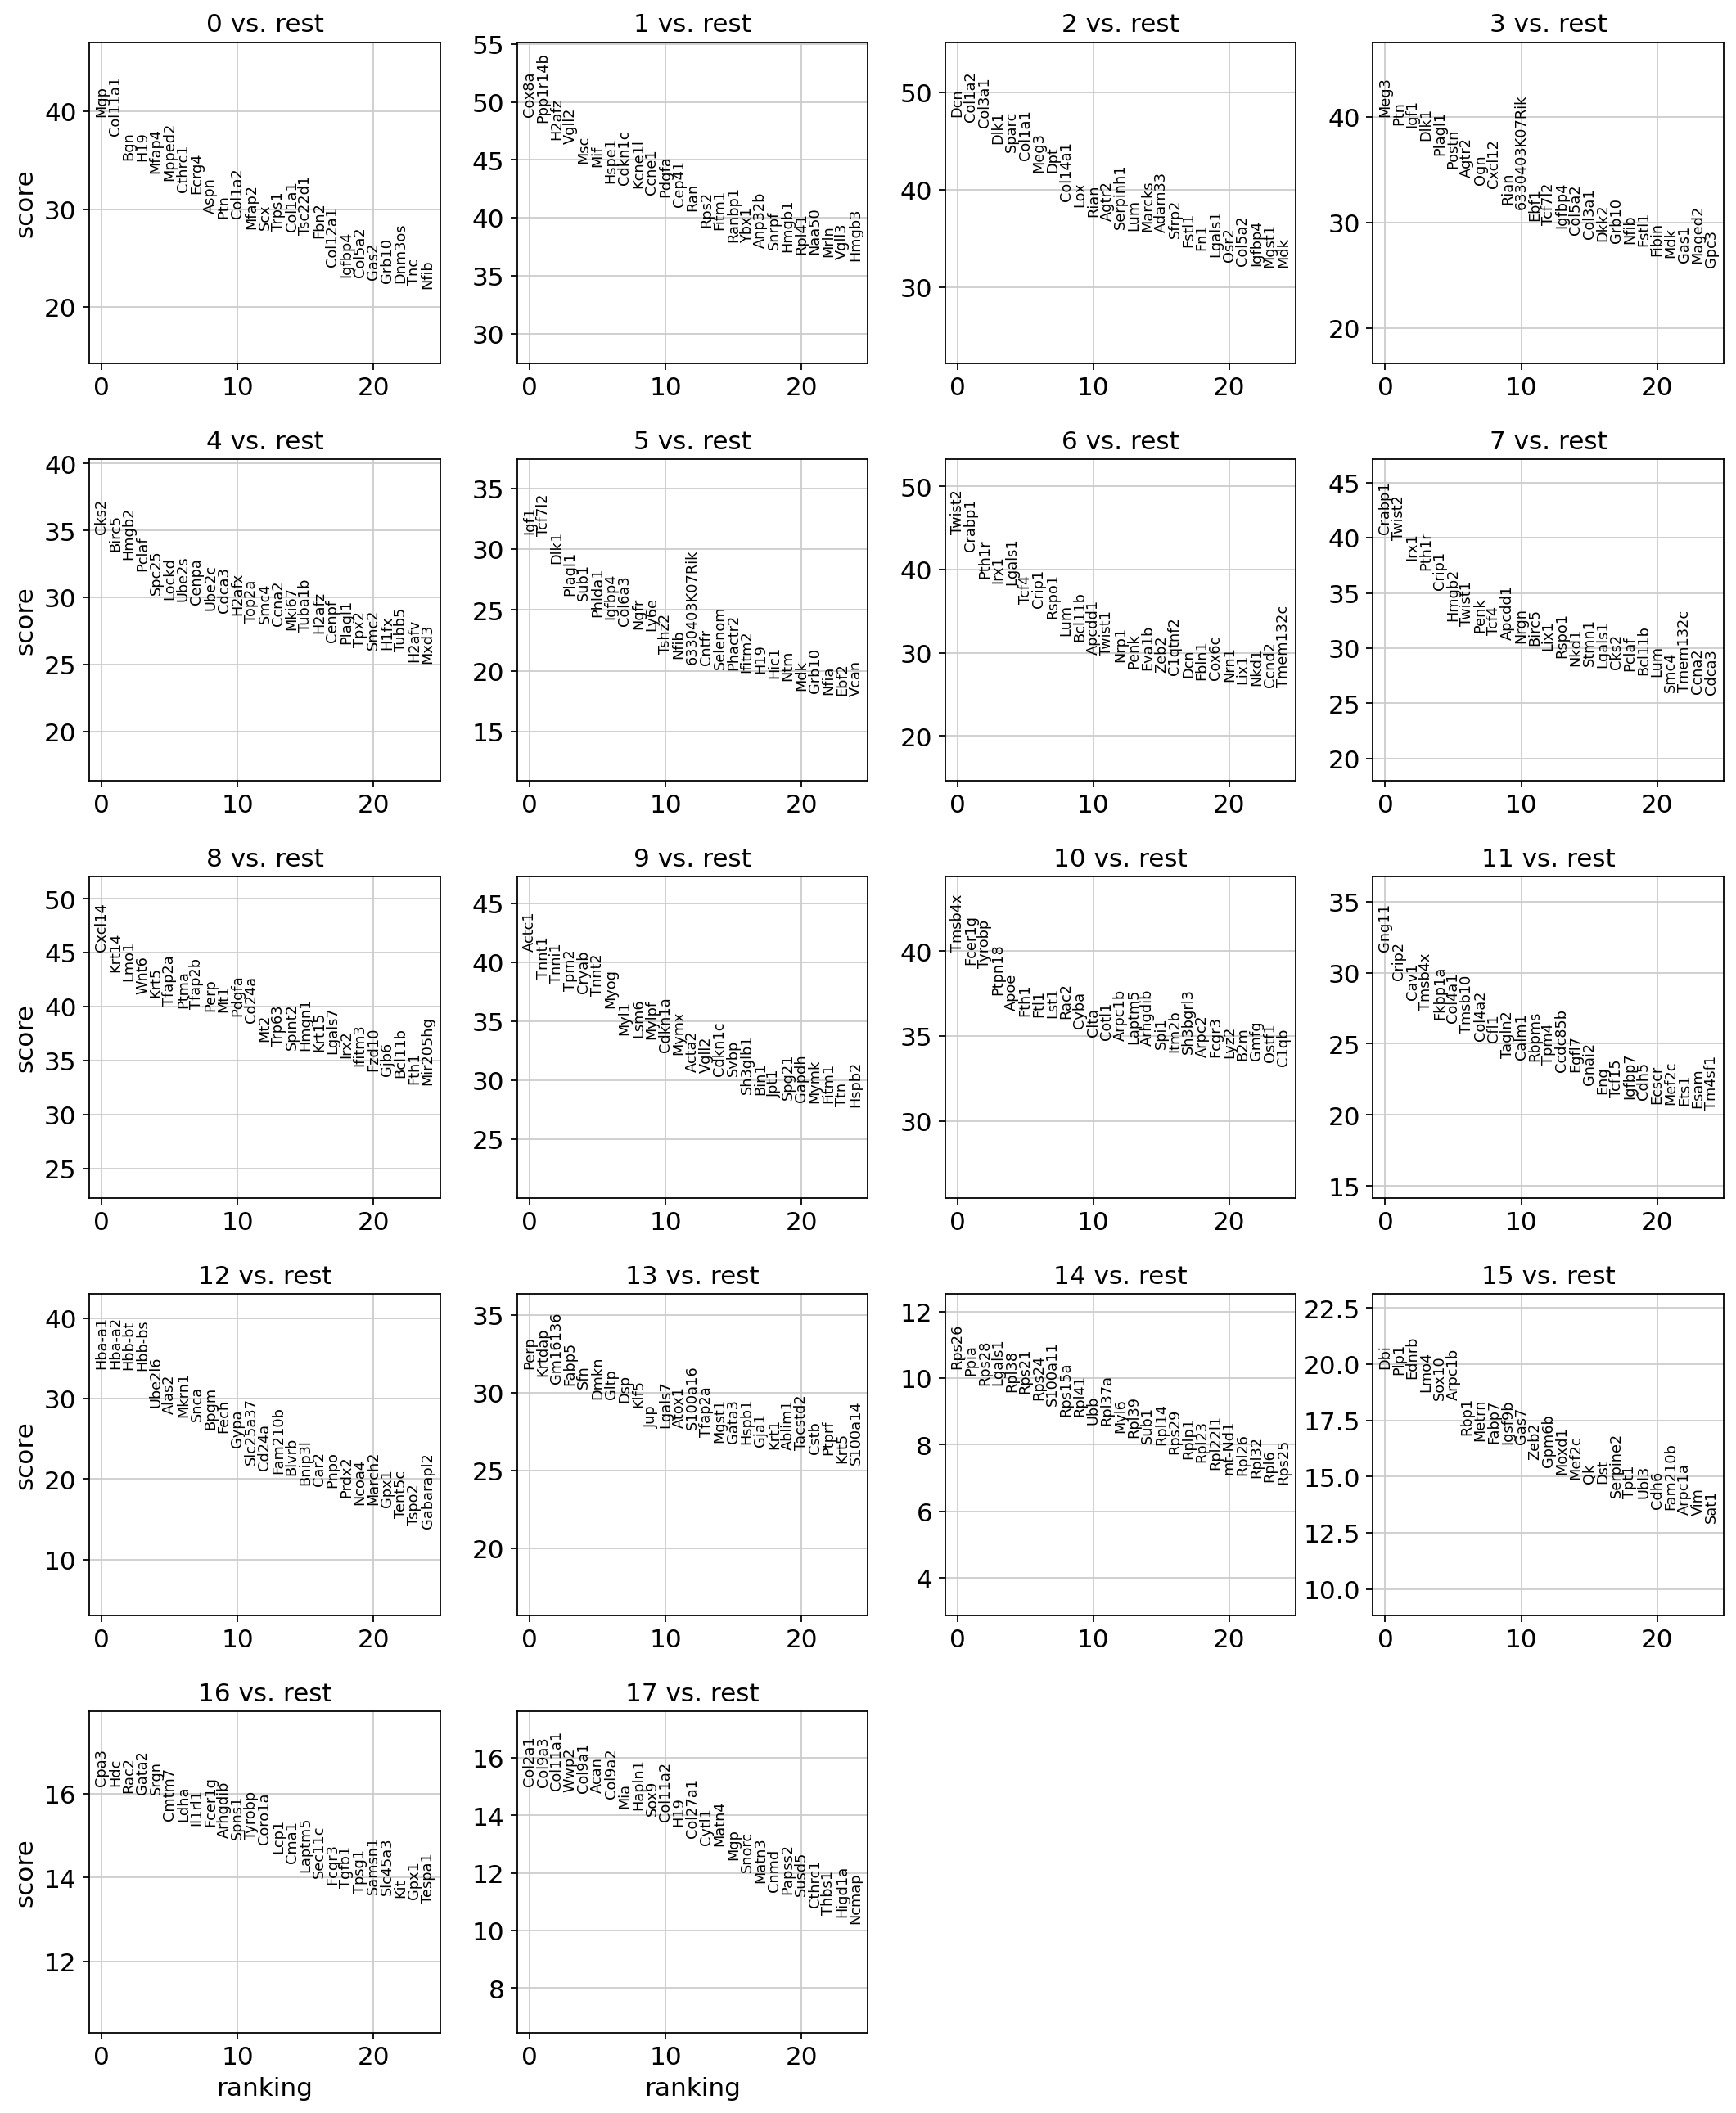

In [0]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', corr_method="bonferroni")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [0]:
adata.write(results_file)

As an alternative, genes can be ranked using logistic regression (see [Natranos et al. (2018)](https://doi.org/10.1101/258566)).

ranking genes
    finished (0:03:04)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


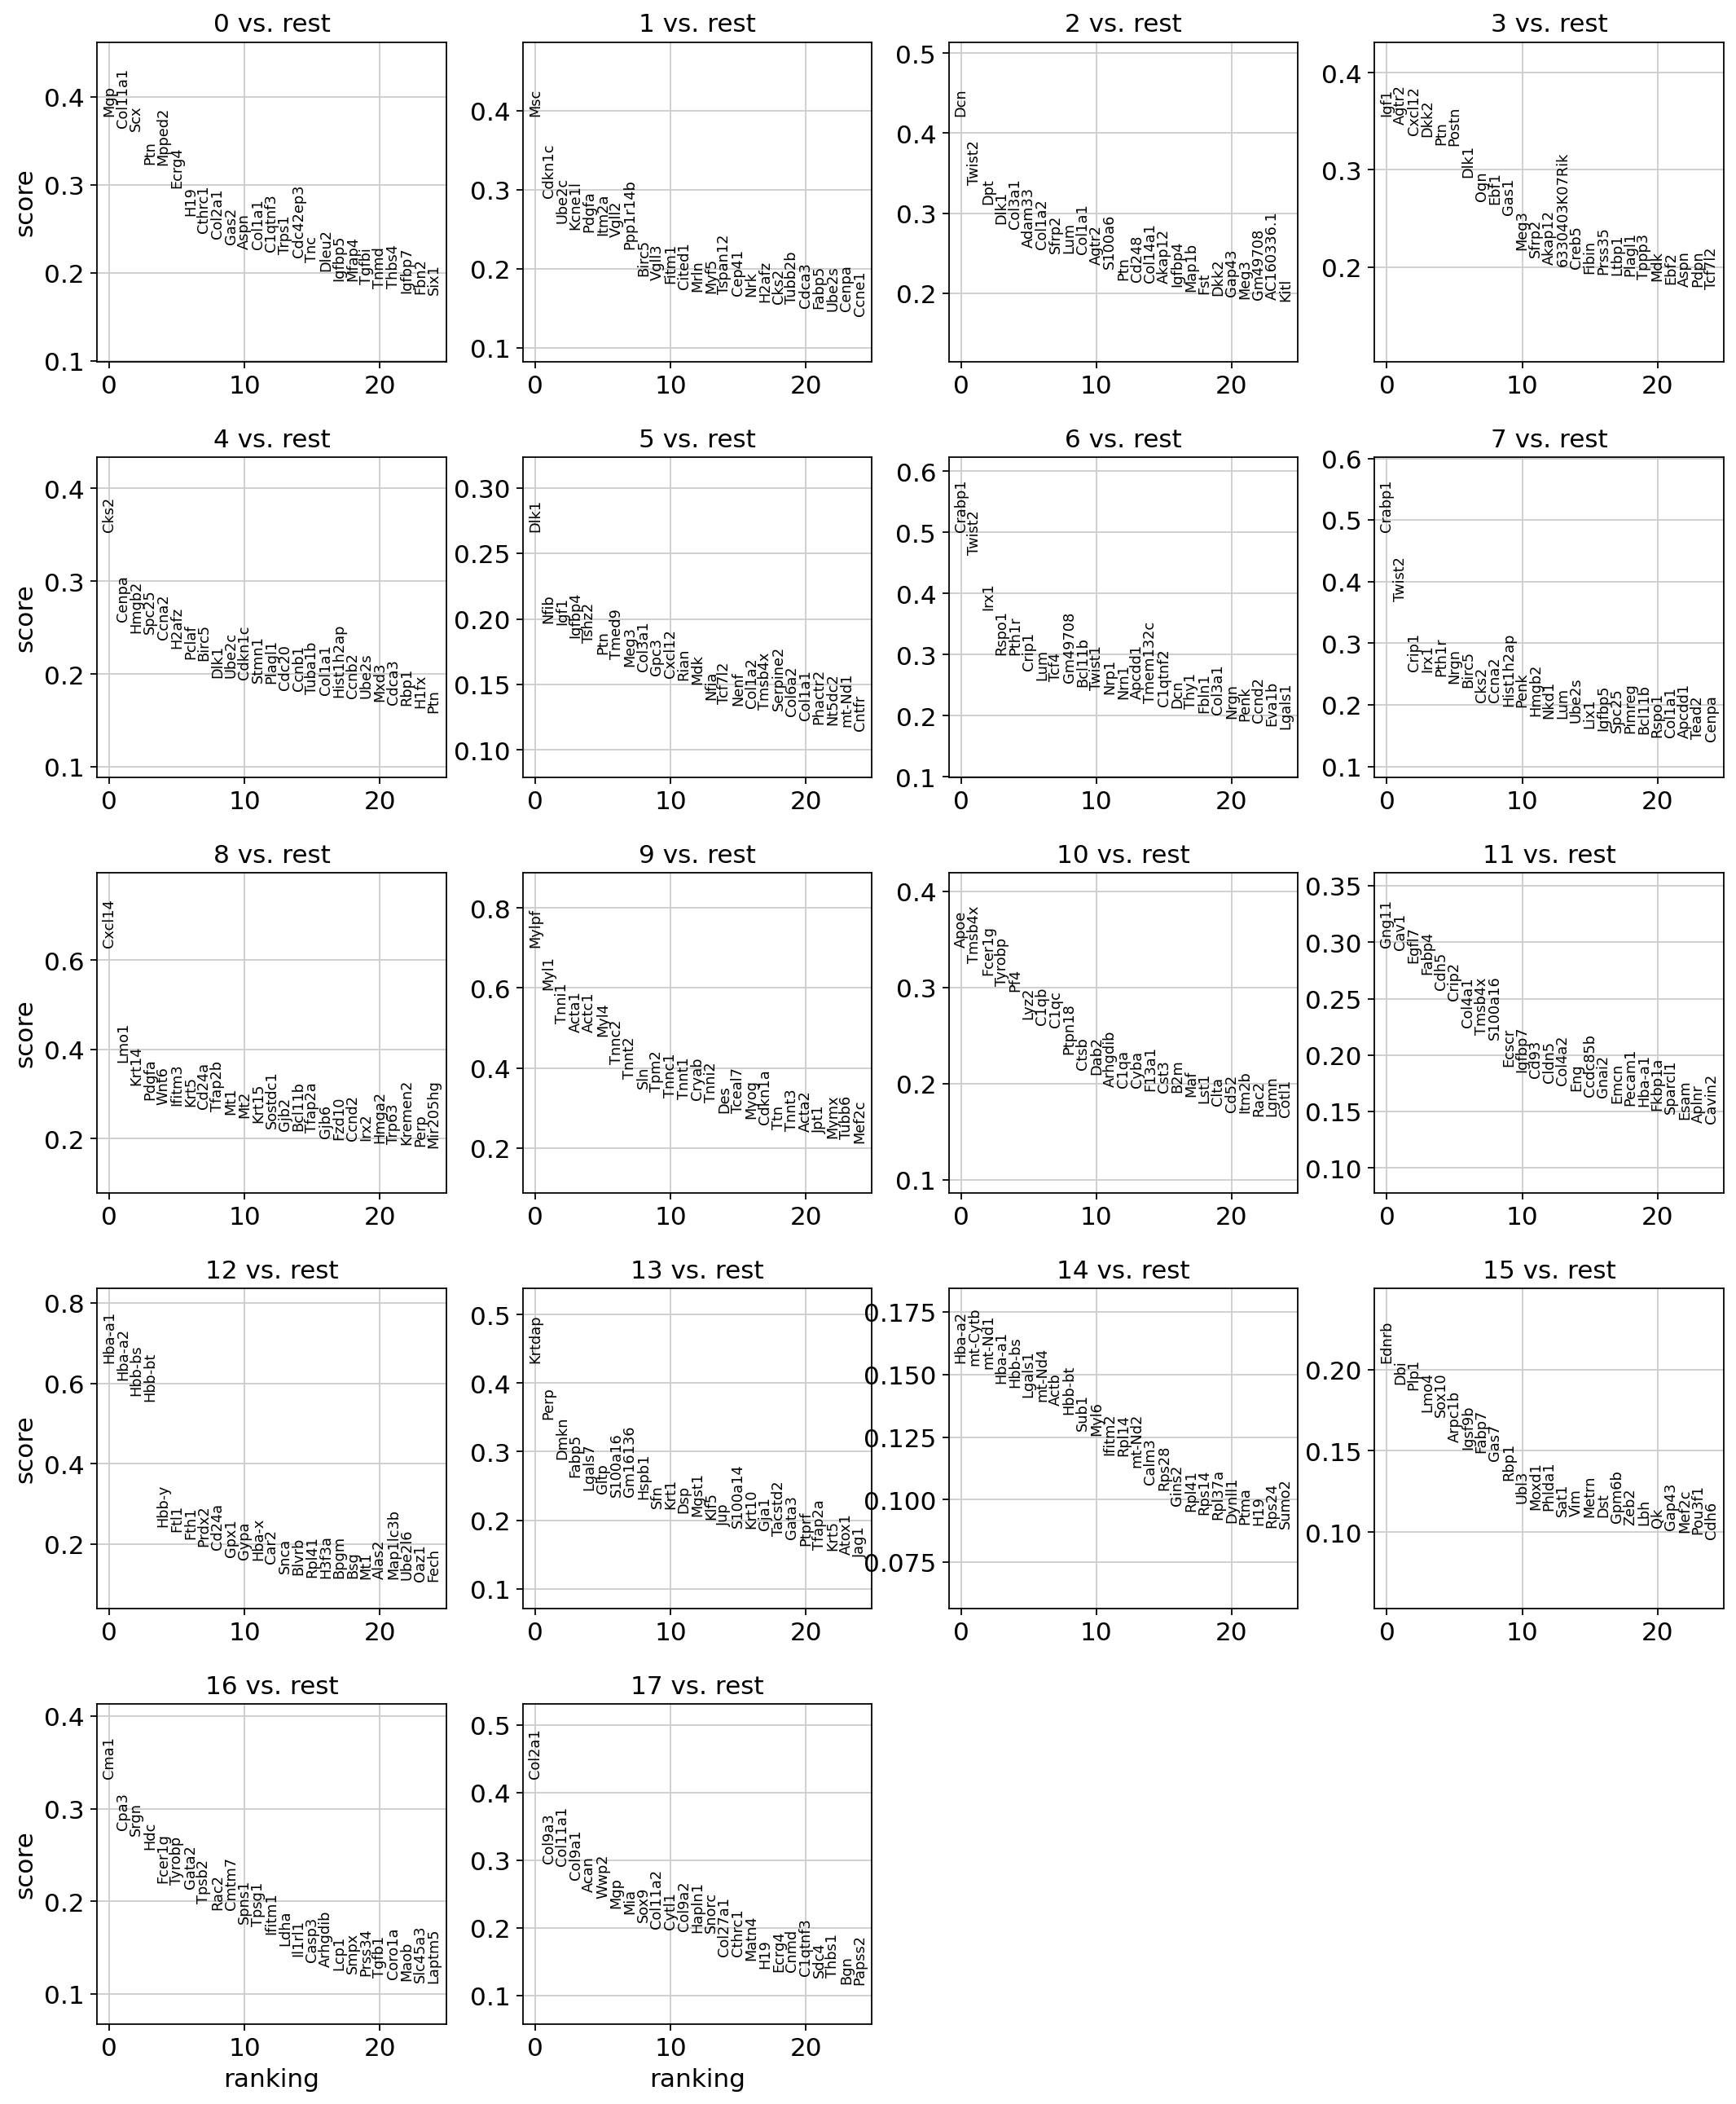

In [0]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

We define a list of marker genes for later reference.

In [0]:
marker_genes = ['Tnc', 'Mrln', 'Fst', 'Postn', 'Pclaf', 'Mdk', 'Lum', 'Crip1',
                'Krt5', 'Tnnt2', 'Pf4', 'Fabp4', 'Ftl1',  
                'Dmkn', 'Myl6', 'Dbi', 'Hdc', 'Sox9']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [0]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [0]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0         1       2       3  ...      14     15     16       17
0      Mgp     Cox8a     Dcn    Meg3  ...   Rps26    Dbi   Cpa3   Col2a1
1  Col11a1  Ppp1r14b  Col1a2     Ptn  ...    Ppia   Plp1    Hdc   Col9a3
2      Bgn     H2afz  Col3a1    Igf1  ...   Rps28  Ednrb   Rac2  Col11a1
3      H19     Vgll2    Dlk1    Dlk1  ...  Lgals1   Lmo4  Gata2     Wwp2
4    Mfap4       Msc   Sparc  Plagl1  ...   Rpl38  Sox10   Srgn   Col9a1

[5 rows x 18 columns]

Get a table with the scores and groups.

In [0]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n            0_p       1_n  ...          16_p     17_n          17_p
0      Mgp   0.000000e+00     Cox8a  ...  5.912418e-59   Col2a1  3.870806e-51
1  Col11a1  1.832651e-308  Ppp1r14b  ...  6.578709e-59   Col9a3  6.343084e-51
2      Bgn  6.351205e-269     H2afz  ...  7.680027e-58  Col11a1  4.544994e-50
3      H19  2.613120e-268     Vgll2  ...  1.396992e-57     Wwp2  8.507784e-50
4    Mfap4  1.405788e-249       Msc  ...  1.501253e-57   Col9a1  1.306961e-49

[5 rows x 36 columns]

Compare to a single cluster. 

ranking genes
    finished (0:00:06)


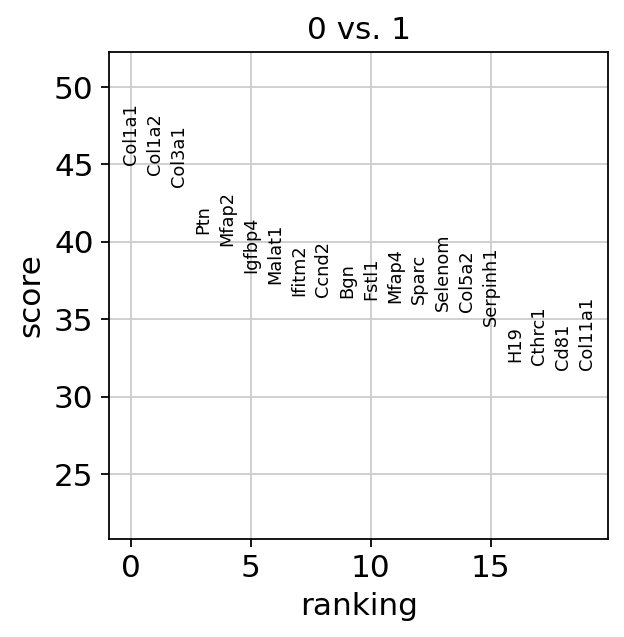

In [0]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

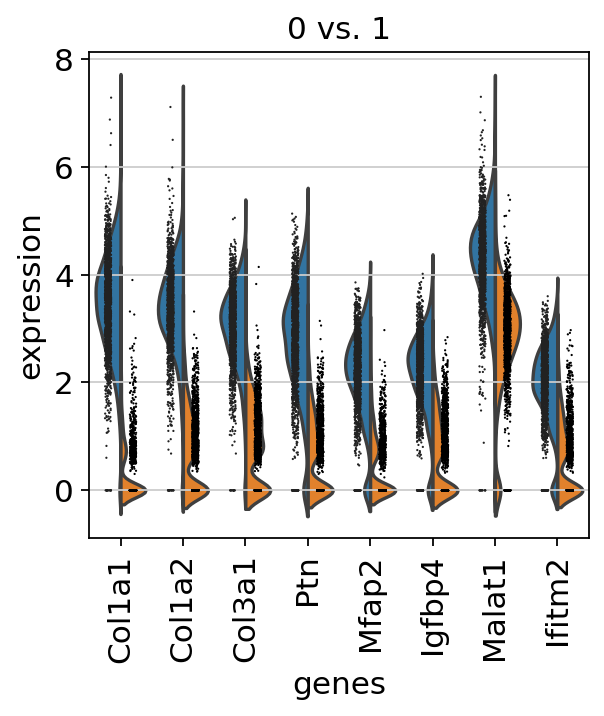

In [0]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reload the object that computed differential expression by comparing to the rest of the groups.

In [0]:
adata = sc.read(results_file)

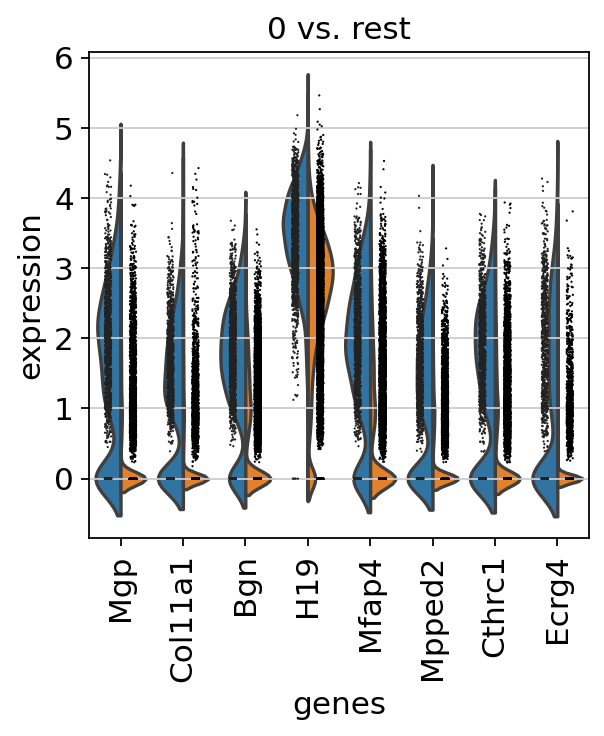

In [0]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

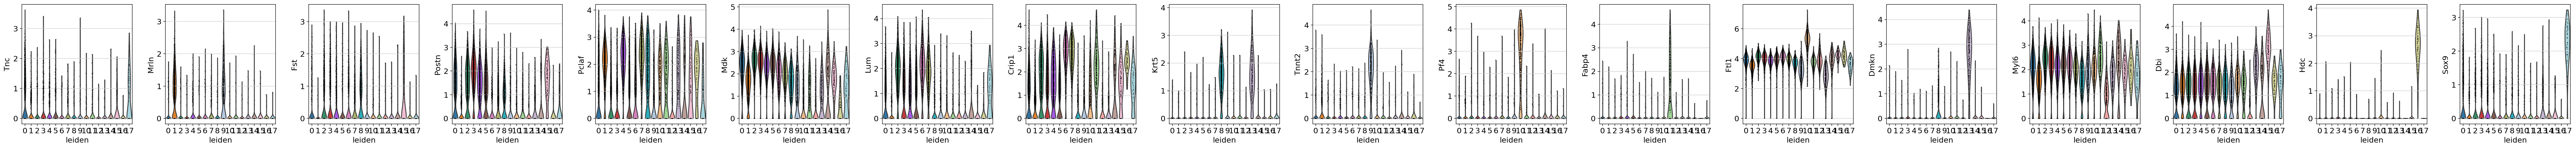

In [0]:
sc.pl.violin(adata, marker_genes, groupby='leiden')

Actually mark the cell types.

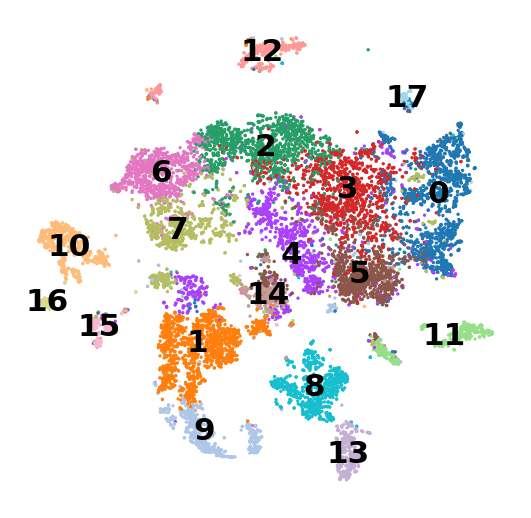

In [0]:
sc.pl.tsne(adata, color='leiden', legend_loc='on data', title='', frameon=False)

Now that we annotated the cell types, let us visualize the marker genes.

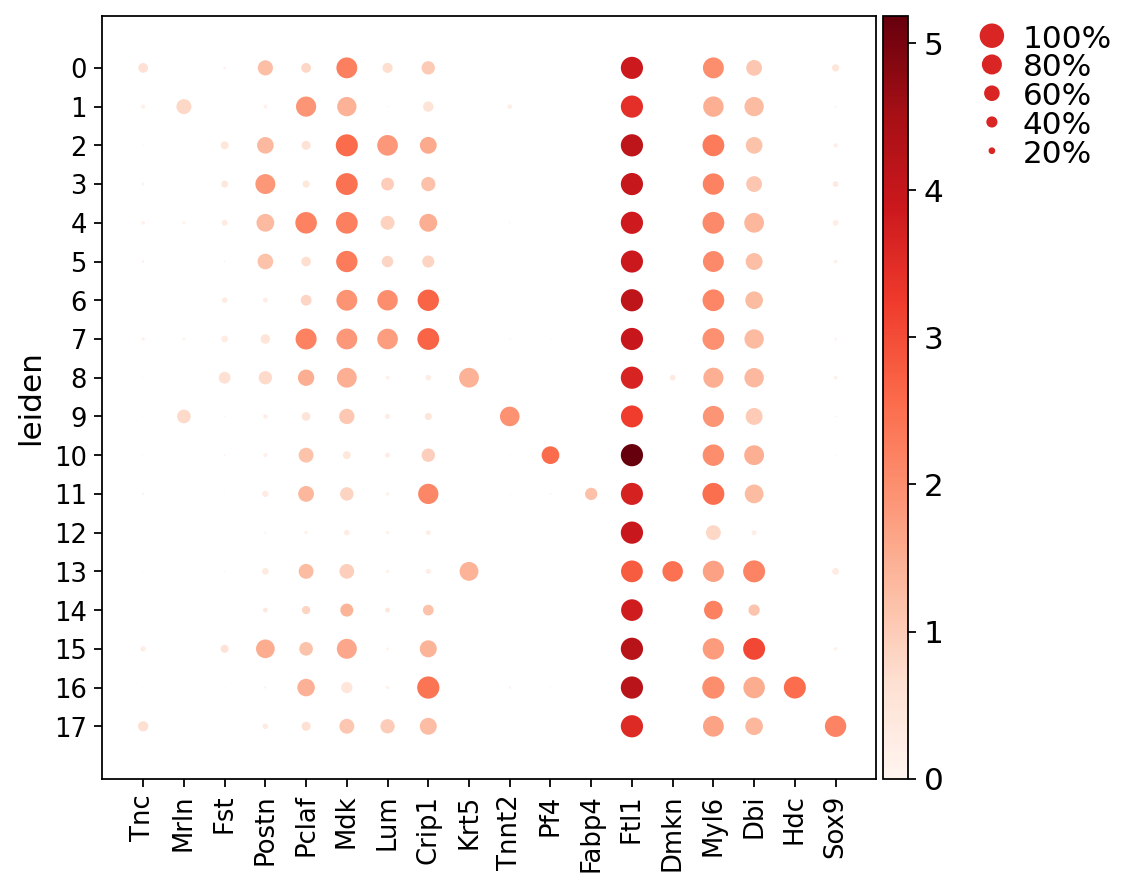

In [0]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='leiden')

There is also a very compact violin plot.

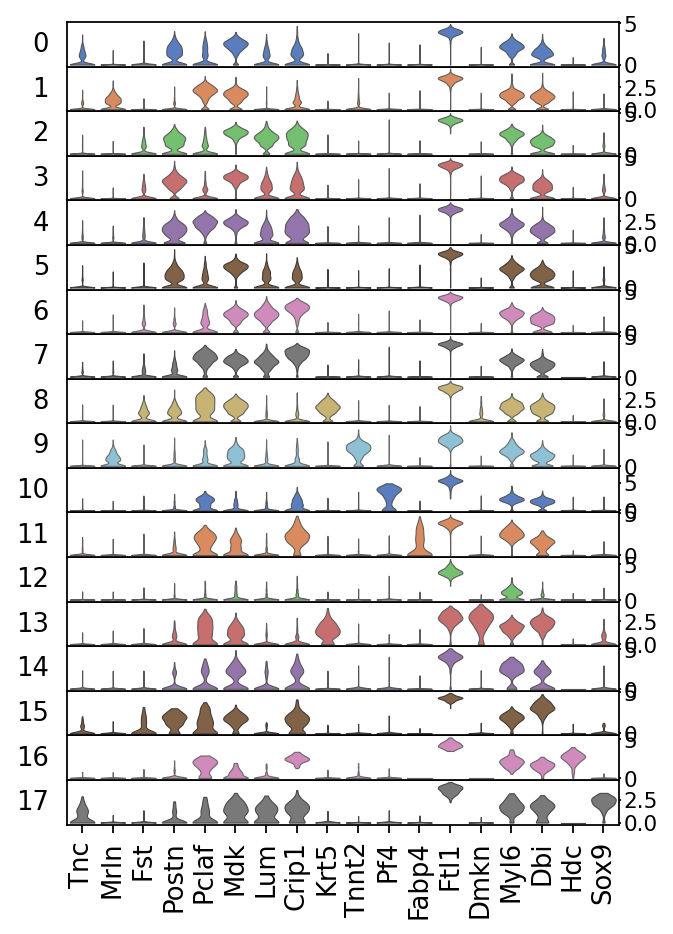

In [0]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90)

Note that as a result of the analysis the adata object has accumulated several annotations:

In [0]:
adata

AnnData object with n_obs × n_vars = 13157 × 29843 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_id', 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [0]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to export to "csv", you have the following options:

In [0]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )

In [0]:
# Running time of the notebook
print("{:.2f} minutes".format((time.time()-start_time)/60))

38.76 minutes


**Feedback**: please report any issues, or submit pull requests for improvements, in the [Github repository where this notebook is located](https://github.com/pachterlab/kallistobustools/blob/master/notebooks/kb_analysis_0_python.ipynb).